# <center> Automated VMAT Planning via Deep Learning Dose Prediction and Subsequent VMAT Optimization </center>


This example demonstrates how to predict the 3D dose distribution using the portpy.ai module and then convert it into a deliverable VMAT plan via SCP-based VMAT optimization available in the portpy.photon module.

**Note**: The portpy.ai module currently predicts the 3D dose distribution using benchmark ECHO IMRT plans available in the PortPy dataset. Consequently, the prediction is not optimized for VMAT. The primary goal of this notebook is to illustrate the feasibility of this automated planning workflow. We hope that in the future, researchers, including our group, will share their optimized prediction models using more data and state-of-the-art AI tools. The VMAT module is based on our recent publications ([Dursun et al 2021](https://iopscience.iop.org/article/10.1088/1361-6560/abee58/meta) and [Dursun et al 2023](https://iopscience.iop.org/article/10.1088/1361-6560/ace09e/meta)). For more information, please refer to [vmat_scp_tutorial.ipynb](https://github.com/PortPy-Project/PortPy/blob/master/examples/vmat_scp_tutorial.ipynb)
 
The main functionalities demonstrated in this notebook are as follows:

1. **Data Access and Preprocessing**: The portpy.ai module allows easy access to curated portpy data, specifically tailored for training deep learning models for dose prediction. It also includes preprocessing steps to prepare the data for use in the models.

2. **Model Training and Testing**: With the portpy.ai module, users can efficiently train and test their deep learning models for dose prediction. This involves using the prepared data to create and fine-tune the models for optimal performance.

3. **Patient-Specific Dose Prediction**: The module enables the creation of personalized dose prediction for available patients in the PortPy database. This feature allows users to estimate the dose distribution for individual patients, aiding in treatment planning. Also, PortPy uses simple UNET model with MAE loss to create dose prediction. Users can implement their own customized models for better prediction and accuracy


4. **VMAT SCP with Predicted Dose**: The predicted dose distribution can be used to create VMAT plan using scp based optimization for treatment planning. The optimal plan can be imported back to a TPS for final dose calculation. Please refer to [vmat_tps_import](https://github.com/PortPy-Project/PortPy/blob/master/examples/vmat_tps_import.ipynb) for more details.

5. **Plan Visualization**: The module offers tools for visualizing treatment plans based on the predicted dose distribution. 




In [1]:
# append portpy ai directory to path
import sys
sys.path.append('..')

In [2]:
import portpy.photon as pp
import SimpleITK as sitk
import os
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt
from portpy.ai.preprocess.predict_using_model import predict_using_model
from portpy.ai.preprocess.data_preprocess import data_preprocess
from portpy.ai.train import train
from portpy.ai.test import test

**Note** When runnig it for the first time please install packages using requirements.txt 

In [7]:
# !pip install -r requirements.txt --user

### 1. Preprocess, train and test using PortPy AI module

In [11]:
in_dir = r'../data' # directory where portpy raw data is located
out_dir = r'../ai_data' # directory where processed data to be stored for training and testing model
# preprocess portpy data
data_preprocess(in_dir, out_dir)

Processing case Lung_Patient_10: 1 of 10 ...
Creating BEV..
Loading sparse influence matrix...
Done
Processing case Lung_Patient_2: 2 of 10 ...
Creating BEV..
Loading sparse influence matrix...
Done
Processing case Lung_Patient_3: 3 of 10 ...
Creating BEV..
Loading sparse influence matrix...
Done
Processing case Lung_Patient_4: 4 of 10 ...
Creating BEV..
Loading sparse influence matrix...
Done
Processing case Lung_Patient_5: 5 of 10 ...
Creating BEV..
Loading sparse influence matrix...
Done
Processing case Lung_Patient_6: 6 of 10 ...
Creating BEV..
Loading sparse influence matrix...
Done
Processing case Lung_Patient_7: 7 of 10 ...
Creating BEV..
Loading sparse influence matrix...
Done
Processing case Lung_Patient_9: 9 of 10 ...
Creating BEV..
Loading sparse influence matrix...
Done


**Note** split the data in train and test folder in the output directory before running further code
e.g. out_dir\train\Lung_Patient_2 out_dir\test\Lung_Patient_9

### 2. Training and testing the model

Train the model. You can change the parameters for the training as shown below

In [ ]:
# Provide only the arguments you want to override
train_options = {
    "dataroot": "../ai_data",
    "checkpoints_dir": "../checkpoints",
    "netG": "unet_128",
    "name": "portpy_test_3",
    "model": "doseprediction3d",
    "direction": "AtoB",
    "lambda_L1": 1,
    "dataset_mode": "dosepred3d",
    "norm": "batch",
    "batch_size": 1,
    "pool_size": 0,
    "display_port": 8097,
    "lr": 0.0002,
    "input_nc": 8,
    "output_nc": 1,
    "display_freq": 10,
    "print_freq": 1,
    "gpu_ids": [0]  # Converted to a list since multiple GPUs may be supported
}

train(train_options)  # Run training directly in Jupyter Notebook

In [ ]:
## You can uncomment and run below in case if you want to run train script from CLI
#!python ../portpy/ai/train.py --dataroot ../ai_data --netG unet_128 --name portpy_test_3 --model doseprediction3d --direction AtoB --lambda_L1 1 --dataset_mode dosepred3d --norm batch --batch_size 1 --pool_size 0 --display_port 8097 --lr 0.0002 --input_nc 8 --output_nc 1 --display_freq 10 --print_freq 1 --gpu_ids 0

Test the model

In [ ]:
test_options = {
    "dataroot": "../ai_data",
    "netG": "unet_128",
    "checkpoints_dir": "../checkpoints",
    "results_dir": "../results",
    "name": "portpy_test_3",
    "phase": "test",
    "mode": "eval",
    "eval": True,  # Boolean flag
    "model": "doseprediction3d",
    "input_nc": 8,
    "output_nc": 1,
    "direction": "AtoB",
    "dataset_mode": "dosepred3d",
    "norm": "batch"
}
test(test_options)

In [ ]:
# !python test.py --dataroot ../../ai_data --netG unet_128 --name portpy_test_2 --phase test --mode eval --eval --model doseprediction3d --input_nc 8 --output_nc 1 --direction AtoB --dataset_mode dosepred3d --norm batch

### 3. Create dose prediction for the PortPy patient

After training the model, users can use their customized model to create dose prediction for the portpy patient

In [17]:
# import the predicted dose back to portpy
patient_id = 'Lung_Patient_6'
model_name = 'portpy_test_2'
pred_dose = predict_using_model(patient_id=patient_id, in_dir=in_dir, out_dir=out_dir, model_name=model_name, checkpoints_dir='../checkpoints', results_dir='../results')

Processing case Lung_Patient_6...
Creating BEV..
Loading sparse influence matrix...
Done


### 4. VMAT SCP based optimization using predicted dose

The predicted dose can then be used to design a simple optimization problem that attempts to mimic the predicted dose (this idea sometime is referred to as "dose-mimicking" in the literature). We use the following optimization problem::

$
   \mbox{Minimize} \quad  ||A^{PTV}\mathbf{\hat{x}}-pred^{ptv}||^2 + ||A^{oar}\mathbf{\hat{x}}-pred^{oar}||^2_{+} + w_{ar}(\text{aperture irregularity objective}) + w_{as}(\text{aperture similarity objective}) 
$

$
\quad \mathbf{\hat{x}} \geq 0
$

where, 1) $\mathbf{\hat{x}}$ refers to the fluence derived from the leaf positions and MUs of all control points in VMAT (please refer ([Dursun et al 2021](https://iopscience.iop.org/article/10.1088/1361-6560/abee58/meta) and [Dursun et al 2023](https://iopscience.iop.org/article/10.1088/1361-6560/ace09e/meta) for more details), 2) $\mathbf{A}$ represents the dose influence matrix corresponding to the control points, and 3) $pred$ represents the predicted dose.
 
The operators $||.||_{+}$  represents the positive part of the input vector and is used to ensure the objective function does not penalize for OAR doses less than the predicted dose. Additionally, there are two extra terms in the objective function to encourage aperture regularity and similarity, enhancing delivery efficiency and accuracy.

**Note**: The optimization problem above can be enhanced in several ways, including: 1) Modifying the first term to ensure the objective function does not penalize doses that are better than the predicted dose for PTV voxels, 2) adding appropriate terms to the objective function to further incentivize doses that are even better than the predicted dose for PTV/OARs, and 3) incorporating hard constraints to ensure that critical clinical constraints are always satisfied. Please note that these modifications would require further attention and could potentially increase computational time.

 

In [19]:
# load portpy data
data = pp.DataExplorer(data_dir=in_dir)
data.patient_id = patient_id
# Load ct and structure set for the above patient using CT and Structures class
ct = pp.CT(data)
ct_arr = ct.ct_dict['ct_hu_3d'][0]
structs = pp.Structures(data)

beam_ids = np.arange(37, 72)
beams = pp.Beams(data, beam_ids=beam_ids)

# load influence matrix based upon beams and structure set
inf_matrix = pp.InfluenceMatrix(ct=ct, structs=structs, beams=beams)

# load clinical criteria from the config files for which plan to be optimized
protocol_name = 'Lung_2Gy_30Fx'
clinical_criteria = pp.ClinicalCriteria(data, protocol_name=protocol_name)

# Loading hyper-parameter values for optimization problem
protocol_name = 'Lung_2Gy_30Fx_vmat'
vmat_opt_params = data.load_config_opt_params(protocol_name=protocol_name)

# # Creating optimization structures (i.e., Rinds, PTV-GTV)
structs.create_opt_structures(opt_params=vmat_opt_params,
                              clinical_criteria=clinical_criteria)

pred_dose_1d = inf_matrix.dose_3d_to_1d(dose_3d=pred_dose)

arcs_dict = {'arcs': [{'arc_id': "01", "beam_ids": beam_ids[0:int(len(beam_ids) / 2)]},
                          {'arc_id': "02", "beam_ids": beam_ids[int(len(beam_ids) / 2):]}]}
# Create arcs object using arcs dictionary and influence matrix
arcs = pp.Arcs(arcs_dict=arcs_dict, inf_matrix=inf_matrix)

# create a plan using ct, structures, beams and influence matrix. Clinical criteria is optional
my_plan = pp.Plan(ct=ct, structs=structs, beams=beams, inf_matrix=inf_matrix, clinical_criteria=clinical_criteria, arcs=arcs)

Creating BEV..
Loading sparse influence matrix...
Done
Creating optimization structures.. It may take some time due to dilation
Optimization structures created!!


In [ ]:
# Initialize Optimization
vmat_opt = pp.VmatScpOptimization(my_plan=my_plan,
                                  opt_params=vmat_opt_params)
# Run Sequential convex algorithm for optimising the plan.
# The final result will be stored in sol and convergence will store the convergence history (i.e., results of each iteration)
sol, convergence = vmat_opt.run_sequential_cvx_algo_prediction(pred_dose_1d=pred_dose_1d, solver='MOSEK', verbose=True)

### 5. Plan visualization

In [ ]:
# Save plan and optimal solution
pp.save_optimal_sol(sol, sol_name='sol_vmat_pred.pkl', path=os.path.join(r'C:\temp', data.patient_id))
pp.save_obj_as_pickle(convergence, obj_name='convergence_pred.pkl', path=os.path.join(r'C:\temp', data.patient_id))
pp.save_plan(my_plan, plan_name='my_plan_vmat_pred.pkl', path=os.path.join(r'C:\temp', data.patient_id))

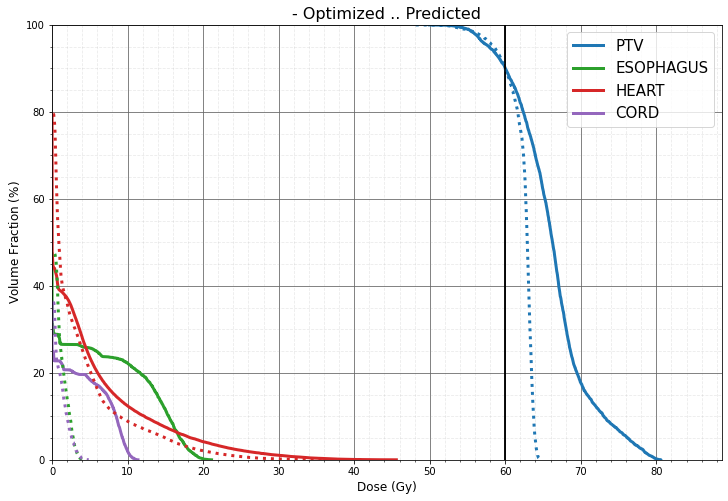

In [24]:
struct_names = ['PTV', 'ESOPHAGUS', 'HEART', 'CORD']
fig, ax = plt.subplots(figsize=(12, 8))
ax = pp.Visualization.plot_dvh(my_plan, sol=sol, struct_names=struct_names, style='solid', ax=ax, norm_flag=True)
ax = pp.Visualization.plot_dvh(my_plan, dose_1d=pred_dose_1d, struct_names=struct_names, style='dotted', ax=ax,
                               norm_flag=True)
ax.set_title('- Optimized .. Predicted', fontsize=16)
plt.show()